In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [2]:
NOISE_DIM =  100
BATCH_SIZE = 10
STEPS_PER_EPOCH = 1520
EPOCHS = 2
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [3]:
NO_LOWER_DIR = "../input/brain-tumor-mri-images-with-slice-classification/original_complete_dataset_with_slice_classification/no/lower_slice/"
# NORMAL_DIR = "../input/brain-mri-images-for-brain-tumor-detection/yes"

# Loading and Preprocessing the Images

In [4]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [5]:
data, labels = load_images(NO_LOWER_DIR)
data.shape, labels.shape

((28, 128, 128), (28,))

## Generate 35 random numbers to index images from data

In [6]:
np.random.seed(SEED)
idxs = np.random.randint(0, 28, 22)

In [7]:
X_train = data[idxs]
X_train.shape

(22, 128, 128)

## Normalize and Reshape the Data

In [8]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(22, 128, 128, 1)

## Plotting The Real Images

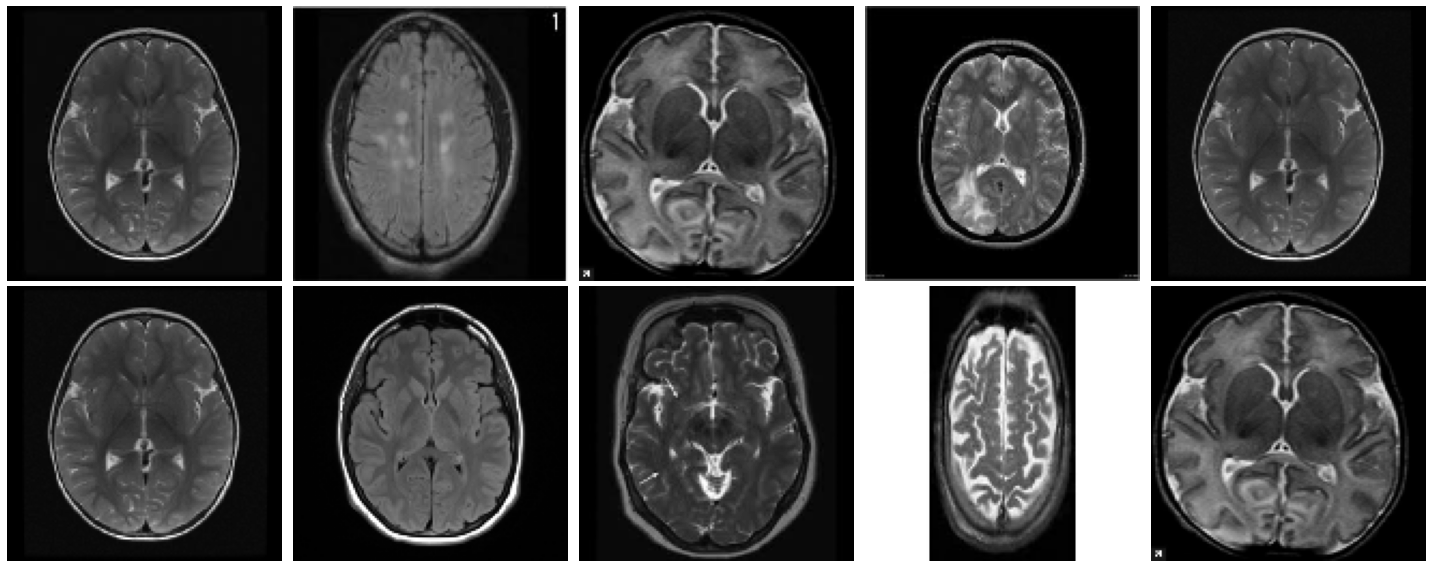

In [9]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

# The Architecture

In [10]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [11]:
def build_discriminator():
    
    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

# Putting it together

In [12]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)   

In [13]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## The Training

100%|██████████| 1520/1520 [04:31<00:00,  5.60it/s]


EPOCH: 1 Generator Loss: 4.2745 Discriminator Loss: 0.1038


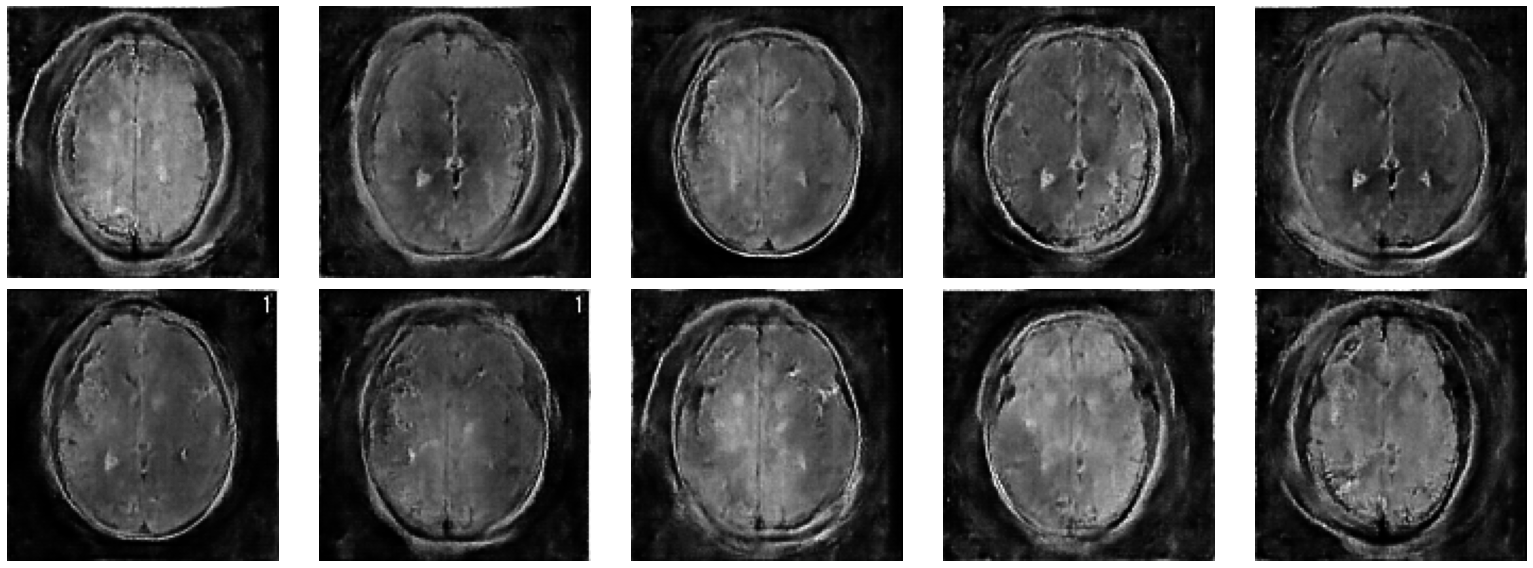

100%|██████████| 1520/1520 [04:23<00:00,  5.78it/s]


EPOCH: 2 Generator Loss: 5.0854 Discriminator Loss: 0.0964


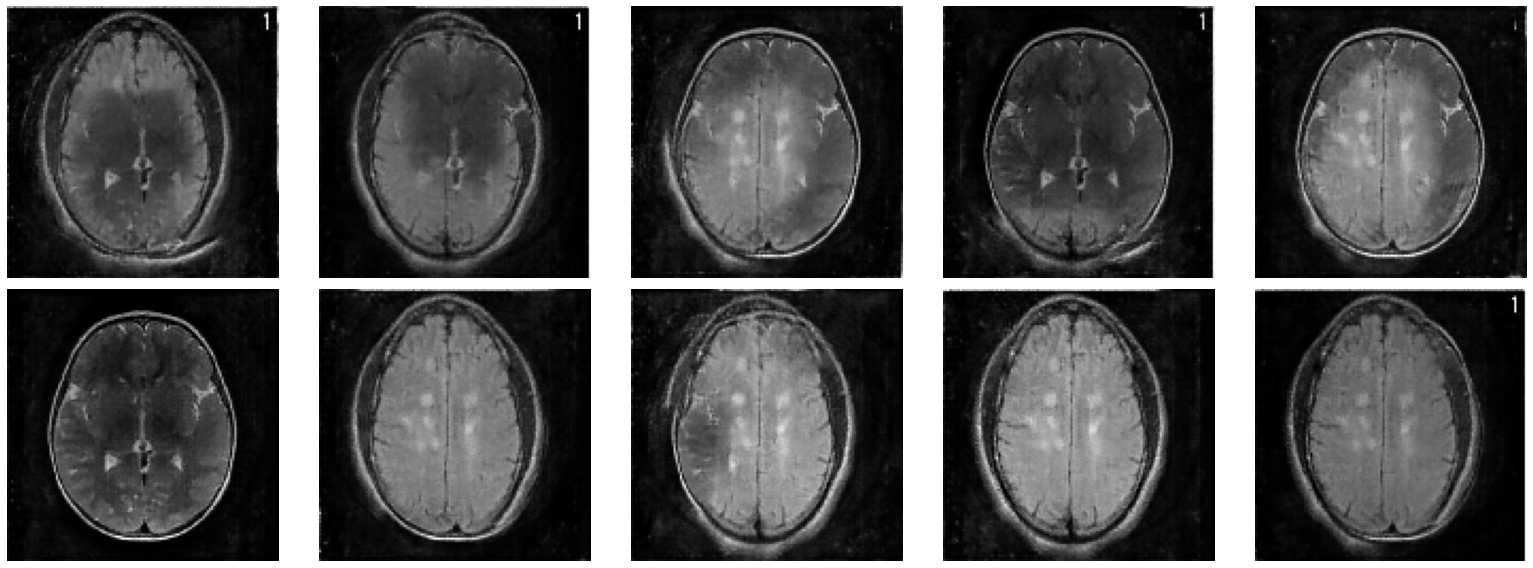

In [14]:
np.random.seed(SEED)
for epoch in range(EPOCHS):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2 * BATCH_SIZE)            # Create labels for both real and fake images
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

# Let's generate some images !

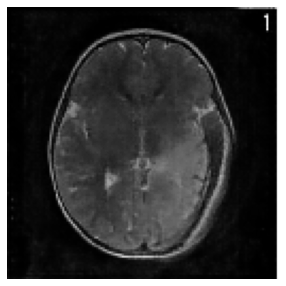

In [23]:
# # noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
# # sample_images(noise, (10,10), (24,20), save=True)
noise = np.random.normal(0, 1, size=(1, NOISE_DIM))
sample_images(noise, (2, 5), save = False)

In [24]:
generator.save('lower_no_generator_model.h5')

In [25]:
for i in range(28):
    noise = np.random.normal(0, 1, size=(1, NOISE_DIM))  # Generate random noise
    generated_image = generator.predict(noise)[0]  # Generate image from noise

    plt.figure(figsize=(22, 8))  # Create a new figure for each image
    plt.imshow(generated_image.reshape((WIDTH, HEIGHT)), cmap ='gray')  # Display the generated image
    plt.axis('off')  # Turn off the axis

    img_name = "gen_" + str(i) + ".png"  # Define image file name
    plt.savefig(img_name , bbox_inches='tight', pad_inches=0)  # Save the image with the given name
    plt.close()  # Close the figure to avoid memory issues

In [26]:
!zip -r no_lower_generates.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/gen_23.png (deflated 7%)
  adding: kaggle/working/gen_7.png (deflated 6%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/gen_2.png (deflated 7%)
  adding: kaggle/working/gen_24.png (deflated 7%)
  adding: kaggle/working/gen_6.png (deflated 7%)
  adding: kaggle/working/gen_25.png (deflated 7%)
  adding: kaggle/working/gen_19.png (deflated 6%)
  adding: kaggle/working/gen_27.png (deflated 7%)
  adding: kaggle/working/gen_3.png (deflated 6%)
  adding: kaggle/working/lower_no_generator_model.h5 (deflated 7%)
  adding: kaggle/working/gen_20.png (deflated 7%)
  adding: kaggle/working/gen_12.png (deflated 7%)
  adding: kaggle/working/gen_22.png (deflated 6%)
  adding: kaggle/working/gen_4.png (deflated 6%)
  adding: kaggle/working/gen_18.png (deflated 7%)
  adding: kaggle/working/gen_0.png (deflated 7%)
  adding: kaggle/working/gen_9.png (deflated 7%)
  adding: kaggle/working/gen_16.png (deflated

In [27]:
!ls

gen_0.png   gen_14.png	gen_2.png   gen_25.png	gen_6.png
gen_1.png   gen_15.png	gen_20.png  gen_26.png	gen_7.png
gen_10.png  gen_16.png	gen_21.png  gen_27.png	gen_8.png
gen_11.png  gen_17.png	gen_22.png  gen_3.png	gen_9.png
gen_12.png  gen_18.png	gen_23.png  gen_4.png	lower_no_generator_model.h5
gen_13.png  gen_19.png	gen_24.png  gen_5.png	no_lower_generates.zip


In [29]:
from IPython.display import FileLink
FileLink(r'no_lower_generates.zip')

/kaggle/working/no_lower_generates.zip

In [30]:
generated_images = generator.predict(noise)
generated_images.shape

(1, 128, 128, 1)

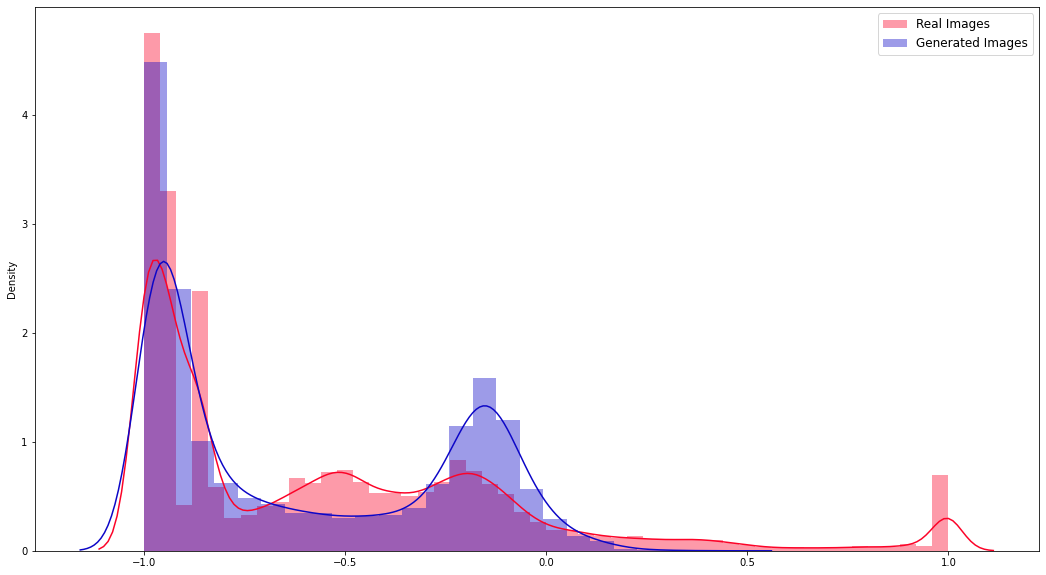

In [31]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()

# Some other testing methods

<p style="font-size:20px">
<ul>
    <li style="font-size:20px">Average Log-likelihood</li>
    <li style="font-size:20px">Inception Score</li>
    <li style="font-size:20px">Wasserstien Metric</li>
</ul>
</p>

# Conclusion

<p style="font-size:20px">
    As we can see from the plot, the distribution of Generated Images is approximately the same as that of the Real Images. From this we can conclude that the generated images are a true representative of the real ones, capturing most of the variations.
</p>

# References

<p style="font-size:20px">
<ul>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1406.2661">Generative Adversarial Networks</a> (2014)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1606.03498">Improved Techniques for Training GANs</a> (2016)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/2108.03235">SMOTified-GAN for class imbalanced pattern classification problems</a> (2021)</li>
</ul>
</p>

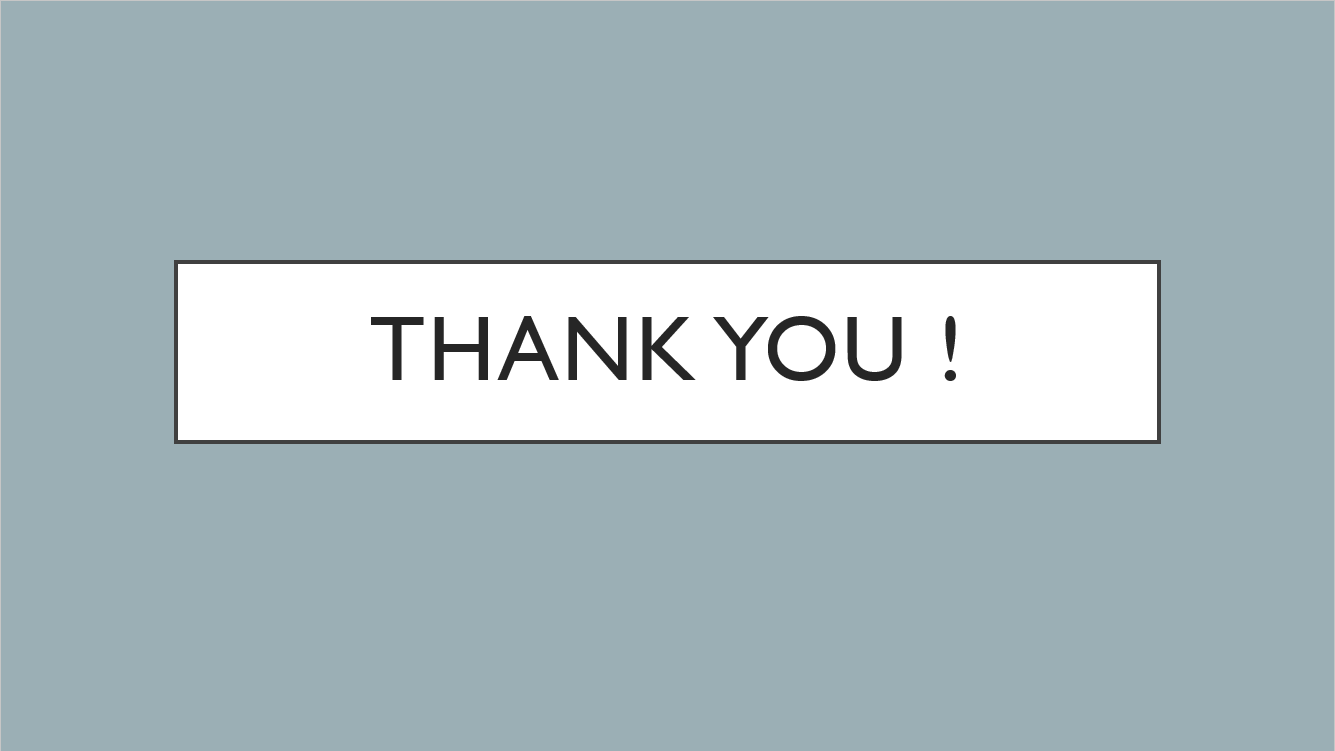